In [1]:
#data analysis libraries
import numpy as np
import pandas as pd

# machine learning
import sklearn

#graph deep learning
import torch
import torch_geometric
import networkx as nx
from d2l import torch as d2l

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# auto load change
%load_ext autoreload
%autoreload 2

# GNN + LSTM
**notice: train and predict all process in `graphlstm_vae_ad.py`**

## load data
metrics will be reshape like : **(num_timeseries, num_micorservice, performance_metrics)**

In [10]:
from util.clean_data import get_service_metric
df = pd.read_csv('DatasetUpdate/MMS (1).csv', header=[0, 1])
metric = df.drop(['TimeStamp', 'label'], axis = 1)
metric.columns.names = ['pod','metric']
tempm = metric.swaplevel('metric','pod',axis=1).stack()
tempm = (tempm-tempm.mean())/(tempm.std())
metric = tempm.unstack().swaplevel('metric','pod',axis=1).stack().unstack()

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(metric, test_size=0.3, shuffle=False)

## train
**only split train and test**

In [12]:
import pickle
from graph_lstm_vae_ad_ver6 import GraphLSTM_VAE_AD

lstm = GraphLSTM_VAE_AD(variational=False)

with open('DatasetUpdate/MMS_topology.pk', 'rb') as f:
    edge_index = pickle.load(f)

Epoch [10/10], Iter [60/66], total_loss: -12822.9219, recon_loss: -12971.1182, kl_loss: 148.1962
valid_loss: [4844.029000418527, 2271.6636483328684, -2049.9373779296875, -5343.480067661831, -7400.746058872768, -8946.295096261161, -10085.776750837054, -10998.97886439732, -11572.52280970982]


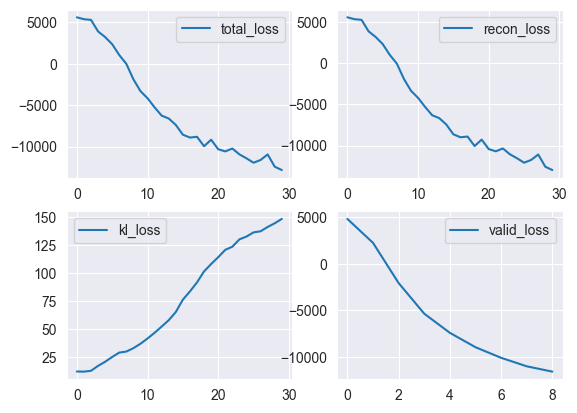

100%|██████████| 28/28 [00:23<00:00,  1.17it/s]


In [13]:
lstm.fit(train, 50, edge_index)

In [14]:
scores_sum, scores_max, outputs = lstm.predict(test, 50, edge_index, 5)

100%|██████████| 41/41 [02:44<00:00,  4.02s/it]


In [39]:
from sklearn.metrics import precision_recall_curve
test_label = df[3059: 3059 + 1286]['label'].to_numpy()
precisions, recalls, thresholds = precision_recall_curve(test_label, scores_sum)

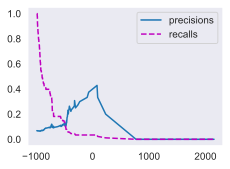

In [49]:
d2l.plot(thresholds, [precisions[:-1], recalls[:-1]], legend=['precisions', 'recalls'])

In [50]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_label, scores_sum)

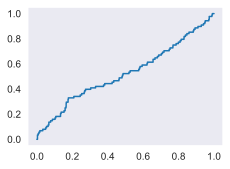

In [51]:
d2l.plot(fpr, tpr)